In [1]:
import numpy as np
import cv2


def kuwahara(orig_img, method='mean', radius=3, sigma=None, grayconv=cv2.COLOR_BGR2GRAY, image_2d=None):
    """
    Get the image filtered with Kuwahara method.
    :param orig_img: original numpy image (support multichannel)
    :type orig_img: :class:`numpy.ndarray`
    :param method: method used to compute the pixels values
    :type method: "gaussian" | "mean"
    :param radius: the window radius (`winsize = 2 * radius + 1`)
    :type radius: `int`
    :param sigma: the sigma used if metod is "gaussian", automatically computed by OpenCV when `None`
    :type sigma: `float` or `None`
    :param grayconv: The OpenCV conversion code to extract grayscale image from `orig_img` (default `COLOR_BGR2GRAY`)
    :type grayconv: `int`
    :param image_2d: The 1-channel image used to compute the variance, if provided instead of `grayconv`
    :type image_2d: `numpy.ndarray`
    :returns: the filtered image
    :rtype: `numpy.ndarray`
    """

    # Filter description:
    # The Kuwahara filter works on a window divided into 4 overlapping
    # subwindows (for a 5x5 pixels example, see below). In each subwindow, the mean and
    # variance are computed. The output value (located at the center of the
    # window) is set to the mean of the subwindow with the smallest variance.
    #
    #     ( a  a  ab   b  b)
    #     ( a  a  ab   b  b)
    #     (ac ac abcd bd bd)
    #     ( c  c  cd   d  d)
    #     ( c  c  cd   d  d)
    #
    # Inspired by:
    #       python-kuwahara by Andrew Dussault, 2015 : https://github.com/adussault/python-kuwahara
    #       which it itself based on original Matlab code from Luca Balbi, 2007

    if orig_img.ndim != 2 and orig_img.ndim != 3:
        raise TypeError("Incorrect number of dimensions (excepted 2 or 3)")

    if not isinstance(radius, int):
        raise TypeError('`radius` must be int')

    if radius < 1:
        raise ValueError('`radius` must be greater or equal 1')

    if method not in ('mean', 'gaussian'):
        raise NotImplementedError('unsupported method %s' % method)

    if method == 'gaussian' and sigma is None:
        sigma = -1
        # then computed by OpenCV as : 0.3 * ((ksize - 1) * 0.5 - 1) + 0.8
        # see: https://docs.opencv.org/master/d4/d86/group__imgproc__filter.html#gac05a120c1ae92a6060dd0db190a61afa

    # convert to float32 if necessary for further math computation
    image = orig_img.astype(np.float32, copy=False)

    if image_2d is not None:
        image_2d = image_2d.astype(image.dtype, copy=False)

    # preallocate these arrays
    avgs = np.empty((4, *image.shape), dtype=image.dtype)
    stddevs = np.empty((4, *image.shape[:2]), dtype=image.dtype)

    if image.ndim == 3:
        if image_2d is None:
            # NOTE this doesn't support float64
            image_2d = cv2.cvtColor(orig_img, grayconv).astype(image.dtype, copy=False)
        avgs_2d = np.empty((4, *image.shape[:2]), dtype=image.dtype)
    elif image.ndim == 2:
        image_2d = image
        avgs_2d = avgs

    # Create a pixel-by-pixel square of the image
    squared_img = image_2d ** 2

    if method == 'mean':
        kxy = np.ones(radius + 1, dtype=image.dtype) / (radius + 1)    # kernelX and kernelY (same)
    elif method == 'gaussian':
        kxy = cv2.getGaussianKernel(2 * radius + 1, sigma, ktype=cv2.CV_32F)
        kxy /= kxy[radius:].sum()   # normalize the semi-kernels
        klr = np.array([kxy[:radius+1], kxy[radius:]])
        kindexes = [[1, 1], [1, 0], [0, 1], [0, 0]]

    # the pixel position for all kernel quadrants
    shift = [(0, 0), (0,  radius), (radius, 0), (radius, radius)]

    # Calculation of averages and variances on subwindows
    for k in range(4):
        if method == 'mean':
            kx = ky = kxy
        elif method == 'gaussian':
            kx, ky = klr[kindexes[k]]
        cv2.sepFilter2D(image, -1, kx, ky, avgs[k], shift[k])
        if image.ndim == 3: # else, this is already done...
            cv2.sepFilter2D(image_2d, -1, kx, ky, avgs_2d[k], shift[k])
        cv2.sepFilter2D(squared_img, -1, kx, ky, stddevs[k], shift[k])
        stddevs[k] = stddevs[k] - avgs_2d[k] ** 2    # compute the final variance on subwindow

    # Choice of index with minimum variance
    indices = np.argmin(stddevs, axis=0)

    # Building the filtered image
    if image.ndim == 2:
        filtered = np.take_along_axis(avgs, indices[None,...], 0).reshape(image.shape)
    else:   # then avgs.ndim == 4
        filtered = np.take_along_axis(avgs, indices[None,...,None], 0).reshape(image.shape)

    return filtered.astype(orig_img.dtype)

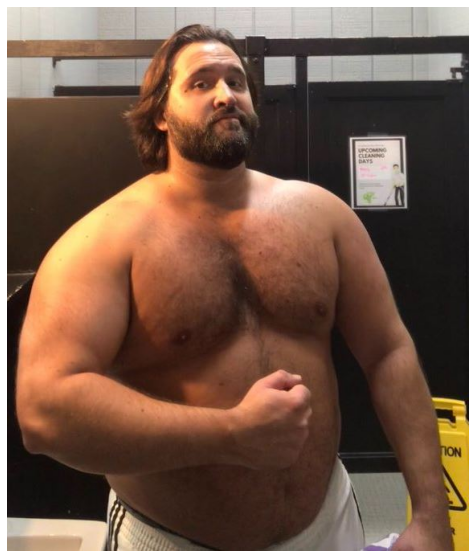

In [2]:

import matplotlib.pyplot as plt
img = cv2.imread("hotdude.jpg")
img = np.flip(img, axis=-1) 
plt.figure(figsize=(15,10))
plt.axis("off")
plt.imshow(img)

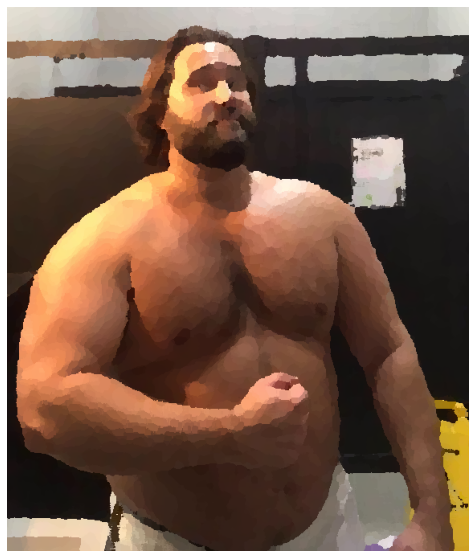

In [7]:
# filtered = kuwahara(img, method='mean', radius=4, sigma=3)
# filtered2 = kuwahara(filtered, method='gaussian', radius=13, sigma=1)
filtered = cv2.xphoto.oilPainting(img, 5, 2)
filtered2 = kuwahara(filtered, method='gaussian', radius=13, sigma=1)
plt.figure(figsize=(15,10))
plt.axis("off")
plt.imshow(filtered)